In [31]:
import matplotlib.pyplot as plt
import pandas as pd
from joblib import load
import numpy as np
from sklearn.svm import NuSVR
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [32]:
'''
AUX Function
'''
#calculate finite diferences of 1st and 2nd order
def finite_difs(curve):
	difs1 = []
	for i in range(curve.shape[0]):
		difs1.append([])
		for j in range(1,curve.shape[1]):
			difs1[i].append(curve[i][j]-curve[i][j-1])
	difs2 = []
	for i in range(curve.shape[0]):
		difs2.append([])
		for j in range(1,len(difs1[0])):
			difs2[i].append(difs1[i][j]-difs1[i][j-1])
	difs1 = np.array(difs1)
	difs2 = np.array(difs2)
	return difs1, difs2

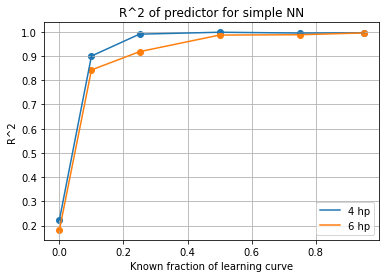

In [33]:
'''
r2 for different known fractions of the learning curve. Using 4hp vs 6hp search space
'''
lc = [0.0, 0.1, 0.25, 0.5, 0.75, 0.95]
#4hp_300
r2 = [0.22403961538598205, 0.8999997566529759, 0.9902491879059602, 0.9981281161265539,0.9948304924468403, 0.9957560886696417]
plt.scatter(lc,r2)
plt.plot(lc, r2,label="4 hp")
#6hp_300
r2 = [0.18199650749836238, 0.8425353570944493, 0.9178920638307584, 0.9865299976933071, 0.9877538295056862, 0.9954100184701985]
plt.scatter(lc,r2,)
plt.plot(lc, r2, label ="6 hp")
plt.xlabel("Known fraction of learning curve")
plt.ylabel("R^2")
plt.legend(loc="lower right")
plt.title("R^2 of predictor for simple NN")
plt.grid()
plt.show()


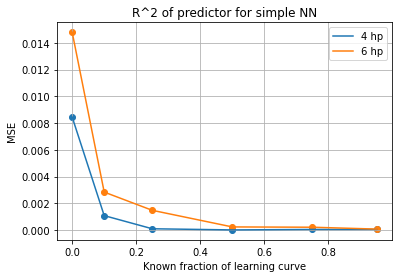

In [34]:
'''
mse of the performance predictor for different known fractions of the learning curve. Using 4hp vs 6hp search space
'''
lc = [0.0, 0.1, 0.25, 0.5, 0.75, 0.95]
#4hp_300
mse = [0.008452663555809713, 0.0010885464511665637, 0.00010614186071653187, 2.0376275889295854e-05, 5.627235407560785e-05, 5.782874930618936e-05]
plt.scatter(lc,mse)
plt.plot(lc, mse,label="4 hp")
#6hp_300
mse = [0.014791127486088108, 0.0028472734274574973, 0.001484674530893162, 0.00024356438961756308, 0.00022143508023885782, 8.299598056538616e-05]
plt.scatter(lc,mse)
plt.plot(lc, mse, label ="6 hp")
plt.xlabel("Known fraction of learning curve")
plt.ylabel("MSE")
plt.legend(loc="upper right")
plt.title("R^2 of predictor for simple NN")
plt.grid()
plt.show()

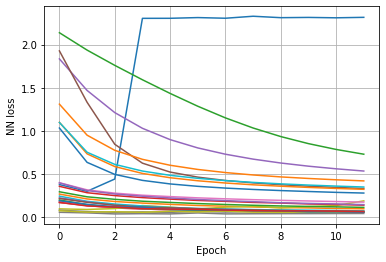

In [37]:
'''
Shows that learning curves may intersect => good to use performance prediction instead of only acc at given point
'''
lc = [i for i in range(12)]
df = pd.read_csv('../data/mnist/all_4hp_rusty.csv')
df = df.iloc[75:100]

for i in range(25):
    loss = df.iloc[i][["loss_"+str(x)for x in range(12)]].values.tolist()
    #plt.scatter(lc,loss,s=1)
    plt.plot(lc,loss)

plt.xlabel("Epoch")
plt.ylabel("NN loss")
plt.grid()

plt.show()

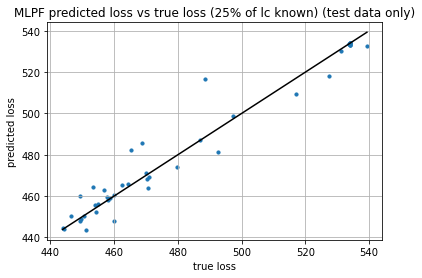

In [38]:
'''
True vs predicted value
'''
df = pd.read_csv('../data/mlpf/delphes_trainings_processed.csv')

#num_epochs = 12
num_epochs = 100

known_curve = 0.25

min_hp_idx = 0

#min_curve_idx = 16
#min_curve_idx = 18
min_curve_idx = 7

#max_hp_idx = 3
#max_hp_idx =  5
max_hp_idx =  6

hps = df[df.columns[min_hp_idx:max_hp_idx+1]].to_numpy()

curve = df[df.columns[min_curve_idx:min_curve_idx+int(num_epochs*known_curve)]].to_numpy()
target = df[df.columns[min_curve_idx+num_epochs-2]].to_numpy()

difs1, difs2 = finite_difs(curve)
X = np.append(np.append(np.append(hps,curve,1),difs1,1),difs2,1)
y = target

_, X, _, y = train_test_split(X, y, test_size=0.2, random_state=0)

x_scaler = load("x_scaler_mlpf.joblib")
y_scaler = load("y_scaler_mlpf.joblib")
X = x_scaler.transform(X)
y = y_scaler.transform(y.reshape(-1, 1))
model = load("model_mlpf.joblib")
y_pred = model.predict(X)

x = y_scaler.inverse_transform(y.reshape(-1, 1))
y = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
plt.scatter(x,y,s=10)
plt.plot([x.min(),x.max()],[x.min(),x.max()],'k')

plt.xlabel("true loss")
plt.ylabel("predicted loss")
plt.grid()
plt.title("MLPF predicted loss vs true loss (25% of lc known) (test data only)")
plt.savefig("../results/mlpf_loss_true_vs_predicted_test.png",dpi=300)
plt.show()

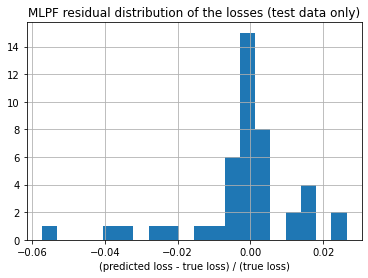

In [39]:
hist_data = ((x - y)/x)
plt.grid()
plt.hist(hist_data, bins=20)
plt.title("MLPF residual distribution of the losses (test data only)")
plt.xlabel("(predicted loss - true loss) / (true loss)")
plt.savefig("../results/mlpf_residual_dist_test.png",dpi=300)

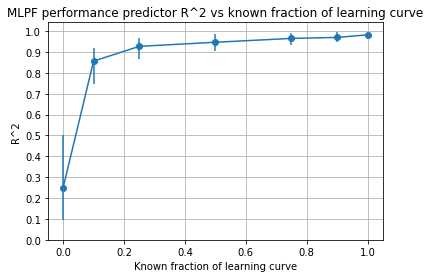

In [40]:
'''
R^2 vs known frac of learning curve
'''

lc = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.]
r2 = []
yerr = [[],[]]
df = pd.read_csv('../data/mlpf/delphes_trainings_processed.csv')
#num_epochs = 12
num_epochs = 100

min_hp_idx = 0

#min_curve_idx = 16
#min_curve_idx = 18
min_curve_idx = 7

#max_hp_idx = 3
#max_hp_idx =  5
max_hp_idx =  6

for known_curve in lc:
	hps = df[df.columns[min_hp_idx:max_hp_idx+1]].to_numpy()
	curve = df[df.columns[min_curve_idx:min_curve_idx+int(num_epochs*known_curve)]].to_numpy()
	target = df[df.columns[min_curve_idx+num_epochs-2]].to_numpy()
	difs1, difs2 = finite_difs(curve)
	X = np.append(np.append(np.append(hps,curve,1),difs1,1),difs2,1)
	y = target	
	x_scaler = MinMaxScaler()
	y_scaler = MinMaxScaler()
	X = x_scaler.fit_transform(X)
	y = y_scaler.fit_transform(y.reshape(-1, 1))
	#instatiate and train predictor
	model = NuSVR()
	cvs = cross_val_score(model, X, y.ravel(), cv = 5, scoring='r2')
	r2.append(cvs.mean())
	yerr[0].append(cvs.mean()-cvs.min())
	yerr[1].append(cvs.max()-cvs.mean())

plt.scatter(lc,r2,)
#plt.plot(lc, r2)
plt.errorbar(lc, r2, yerr=yerr)
plt.xlabel("Known fraction of learning curve")
plt.ylabel("R^2")
plt.title("MLPF performance predictor R^2 vs known fraction of learning curve")
plt.grid()
plt.yticks(np.arange(0., 1.+0.1, 0.1))
plt.savefig("../results/mlpf_r2_vs_lc.png",dpi=300)
plt.show()
